In [1]:
# %matplotlib widget

from __future__ import annotations

import re
from collections import defaultdict
from dataclasses import dataclass, field
from itertools import permutations, product
from math import inf
from random import choice

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from mpl_toolkits.mplot3d import axes3d
from numpy import int_, object_
from numpy.typing import NDArray
from test_utilities import run_tests_params
from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())

<link href="style.css" rel="stylesheet"></link>
<article class="day-desc read-aloud" id="h5o-5"><h2>--- Day 14: Reindeer Olympics ---</h2><p>This year is the Reindeer Olympics!  Reindeer can fly at high speeds, but must rest occasionally to recover their energy.  Santa would like to know which of his reindeer is fastest, and so he has them race.</p>
<p>Reindeer can only either be <em>flying</em> (always at their top speed) or <em>resting</em> (not moving at all), and always spend whole seconds in either state.</p>
<p>For example, suppose you have the following Reindeer:</p>
<ul>
<li>Comet can fly <em>14 km/s for 10 seconds</em>, but then must rest for <em>127 seconds</em>.</li>
<li>Dancer can fly <em>16 km/s for 11 seconds</em>, but then must rest for <em>162 seconds</em>.</li>
</ul>
<p>After one second, Comet has gone 14 km, while Dancer has gone 16 km.  After ten seconds, Comet has gone 140 km, while Dancer has gone 160 km.  On the eleventh second, Comet begins resting (staying at 140 km), and Dancer continues on for a total distance of 176 km.  On the 12th second, both reindeer are resting.  They continue to rest until the 138th second, when Comet flies for another ten seconds.  On the 174th second, Dancer flies for another 11 seconds.</p>
<p>In this example, after the 1000th second, both reindeer are resting, and Comet is in the lead at <em><code>1120</code></em> km (poor Dancer has only gotten <code>1056</code> km by that point).  So, in this situation, Comet would win (if the race ended at 1000 seconds).</p>
<p>Given the descriptions of each reindeer (in your puzzle input), after exactly <code>2503</code> seconds, <em>what distance has the winning reindeer traveled</em>?</p>
</article>


In [2]:
s = """
Comet can fly 14 km/s for 10 seconds, but then must rest for 127 seconds.
Dancer can fly 16 km/s for 11 seconds, but then must rest for 162 seconds.
"""


@dataclass(frozen=True, slots=True)
class Reindeer:
    name: str
    fly_speed: int
    fly_duration: int
    rest_duration: int

    def run(self, duration: int) -> int:
        full_duration = self.fly_duration + self.rest_duration
        full_duration_distance = self.fly_duration * self.fly_speed
        count_full_durations = duration // full_duration
        rest_duration = duration % full_duration
        distance = count_full_durations * full_duration_distance
        if rest_duration < self.fly_duration:
            distance += rest_duration * self.fly_speed
        else:
            distance += full_duration_distance
        return distance

    def give_distance_per_second(self, duration: int) -> list[int]:
        distance = []

        full_duration = self.fly_duration + self.rest_duration
        total_distance = 0
        for t in range(0, duration, full_duration):
            for tt in range(t, min(t + self.fly_duration, duration)):
                total_distance += self.fly_speed
                distance.append(total_distance)
            for _ in range(tt + 1, min(tt + 1 + self.rest_duration, duration)):
                distance.append(total_distance)
        return distance


def parse(s: str) -> list[Reindeer]:
    reindeers = []
    for l in s.strip().splitlines():
        fly, rest = l.split(",")
        name, _, _, speed, _, _, fly_duration, *_ = fly.split(" ")
        *_, rest_duration, _ = rest.split(" ")
        reindeers.append(
            Reindeer(name, int(speed), int(fly_duration), int(rest_duration))
        )
    return reindeers


def reindeer_olympics(s: str, duration: int) -> int:
    reindeers = parse(s)
    return max(r.run(duration) for r in reindeers)


comet = Reindeer(name="Comet", fly_speed=14, fly_duration=10, rest_duration=127)
dancer = Reindeer(name="Dancer", fly_speed=16, fly_duration=11, rest_duration=162)

assert comet.run(1_000) == 1120
assert dancer.run(1_000) == 1056

assert reindeer_olympics(s, 1_000) == 1120

In [3]:
with open("../input/day14.txt") as f:
    fs = f.read()
print(reindeer_olympics(fs, 2503))

2660


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>2660</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>Seeing how reindeer move in bursts, Santa decides he's not pleased with the old scoring system.</p>
<p>Instead, at the end of each second, he awards one point to the reindeer currently in the lead.  (If there are multiple reindeer tied for the lead, they each get one point.)  He keeps the traditional 2503 second time limit, of course, as doing otherwise would be <span title="It also risks choosing a duration that isn't coprime with the cycle times of each reindeer.">entirely ridiculous</span>.</p>
<p>Given the example reindeer from above, after the first second, Dancer is in the lead and gets one point.  He stays in the lead until several seconds into Comet's second burst: after the 140th second, Comet pulls into the lead and gets his first point.  Of course, since Dancer had been in the lead for the 139 seconds before that, he has accumulated 139 points by the 140th second.</p>
<p>After the 1000th second, Dancer has accumulated <em><code>689</code></em> points, while poor Comet, our old champion, only has <code>312</code>.  So, with the new scoring system, Dancer would win (if the race ended at 1000 seconds).</p>
<p>Again given the descriptions of each reindeer (in your puzzle input), after exactly <code>2503</code> seconds, <em>how many points does the winning reindeer have</em>?</p>
</article>

</main>


{'Comet': 312, 'Dancer': 689}
689


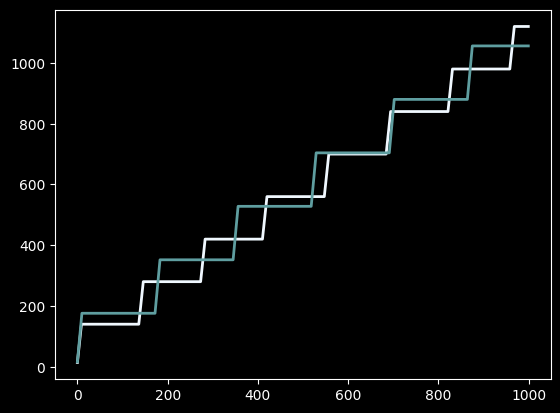

In [4]:
from tabulate import tabulate


def plot(reindeers: list[Reindeer], duration: int) -> None:
    t = range(duration)
    _, ax = plt.subplots()

    for i, r in enumerate(reindeers):
        ax.plot(
            t,
            r.give_distance_per_second(duration),
            linewidth=2.0,
            color=COLORS[(i * 13) % len(COLORS)],
        )

    plt.show()


def pointed_reindeer_olympics(s: str, duration: int) -> dict[str, int]:
    reindeers = parse(s)
    times, points = {}, {}

    for r in reindeers:
        times[r.name] = r.give_distance_per_second(duration)
        points[r.name] = 0

    for t in range(duration):
        max_distance = -inf
        max_rs = []

        for r in times:
            if times[r][t] > max_distance:
                max_distance = times[r][t]
                max_rs = [r]
            elif times[r][t] == max_distance:
                max_rs.append(r)

        for r in max_rs:
            points[r] += 1

    return points


def winning_points(s: str, duration: int) -> int:
    return max(pointed_reindeer_olympics(s, duration).values())


print(pointed_reindeer_olympics(s, 1_000))
print(winning_points(s, 1_000))

plot(parse(s), 1_000)

{'Vixen': 469, 'Rudolph': 188, 'Donner': 589, 'Blitzen': 1256, 'Comet': 158, 'Cupid': 307, 'Dasher': 9, 'Dancer': 0, 'Prancer': 504}
1256


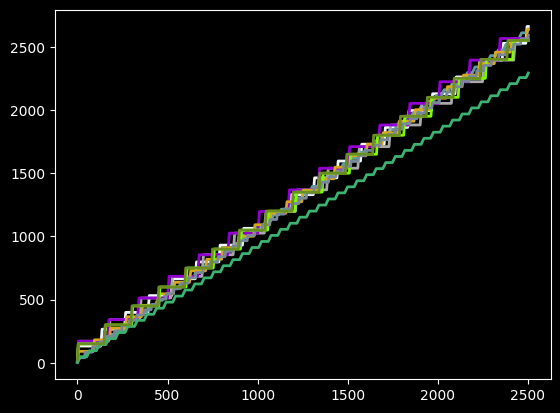

In [5]:
print(pointed_reindeer_olympics(fs, 2_503))
print(winning_points(fs, 2_503))
plot(parse(fs), 2_503)

<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>1256</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>
<p>At this point, you should <a href="/2015">return to your Advent calendar</a> and try another puzzle.</p>
<p>If you still want to see it, you can <a href="14/input" target="_blank">get your puzzle input</a>.</p>
<p>You can also <span class="share">[Share<span class="share-content">on
  <a href="https://twitter.com/intent/tweet?text=I%27ve+completed+%22Reindeer+Olympics%22+%2D+Day+14+%2D+Advent+of+Code+2015&amp;url=https%3A%2F%2Fadventofcode%2Ecom%2F2015%2Fday%2F14&amp;related=ericwastl&amp;hashtags=AdventOfCode" target="_blank">Twitter</a>
  <a href="javascript:void(0);" onclick="var ms; try{ms=localStorage.getItem('mastodon.server')}finally{} if(typeof ms!=='string')ms=''; ms=prompt('Mastodon Server?',ms); if(typeof ms==='string' &amp;&amp; ms.length){this.href='https://'+ms+'/share?text=I%27ve+completed+%22Reindeer+Olympics%22+%2D+Day+14+%2D+Advent+of+Code+2015+%23AdventOfCode+https%3A%2F%2Fadventofcode%2Ecom%2F2015%2Fday%2F14';try{localStorage.setItem('mastodon.server',ms);}finally{}}else{return false;}" target="_blank">Mastodon</a></span>]</span> this puzzle.</p>
</main>
